# EH_01_Data Wrangling March of Empires Reviews
Prepared by Eric Hui

## Purpose
Examining the reviews for the game 'March of Empires' on the Steam store

## Methodology
Using Python and requests, we will web scrape data using Steam's Web API. Each Steam game has an associated appid

For March of Empires, the URL on Steam is https://store.steampowered.com/app/702320/March_of_Empires/, and the appid is 702320.

## Import dependencies

In [1]:
from bs4 import BeautifulSoup
from itertools import chain
from fake_useragent import UserAgent
import requests
import json

import time
import random
from getpass import getpass

import pandas as pd
import string
import re
import enchant

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [2]:
# Gameloft appids on Steam
GAMELOFT = {
            'Iron Blade: Medieval RPG' : 1087730,
            'Dungeon Hunter 5' : 982510,
            'Dungeon Hunter Champions' : 915580,
            'Modern Combat 5' : 921060,
            'Modern Combat Versus' : 723780,
            'War Planet Online: Global Conquest' : 719640,
            'March of Empires' : 702320,
            'Sniper Fury' : 591740
            }        

Using Steam's API, it is possible to retrieve reviews by players for a particular game.

Review calls take the form:

    'http://store.steampowered.com/appreviews/<APP_ID>?json=1'
    
Reference: https://partner.steamgames.com/doc/store/getreviews

Steam API General Reference: https://partner.steamgames.com/doc/webapi


# Data import
We retrieve all the required data for the analysis.

### Helper Functions

In [3]:
def get_reviews_batch(appid, cursor):
    '''
    Get a batch of reviews if a valid http request is made.
    Args: appid --> int, cursor --> str
    Returns: batch --> dict/None
    '''
    parameters = {
            'filter':'recent',
            'language':'all',
            #'day_range':'365',
            'cursor': cursor,
            'review_type':'all',
            'purchase_type':'all',
            'num_per_page':'100',
            }
    reviews_uri = f'http://store.steampowered.com/appreviews/{appid}?json=1'
    
    # header not necessary but help mimic real user
    r = requests.get(reviews_uri, params=parameters, headers={'User-Agent': 'Mozilla/5.0'}) 
    
    batch = None
    if r.ok:
        #print('Request good. JSON instance returned.')
        batch = r.json()
    else:
        print('Invalid or bad Request')
    return batch

def get_all_reviews(appid):
    '''
    Get all reviews for a given app if a valid http request is made.
    Args: appid --> int
    Returns: reviews --> list
    '''
    first_batch = get_reviews_batch(appid,'*') # start cursor at *
    total_num = first_batch['query_summary']['total_reviews'] # total number of reviews
    reviews = first_batch['reviews'] # reviews so far
    cursor = first_batch['cursor'] # new cursor
    print(f'Total of {len(reviews)}/{total_num} retreived.')
    #print(f'Cursor: {cursor}')

    while len(reviews) < total_num:
        # wait a little bit
        time.sleep(0.2)
        
        next_batch = get_reviews_batch(appid, cursor) # get new batch
        cursor = next_batch['cursor'] # set cursor to latest batch cursor
        reviews.extend(next_batch['reviews']) # attach new batch
        
        print(f'Total of {len(reviews)}/{total_num} retreived.')
        #print(f'Cursor: {cursor}')

    print('All reviews retrieved.')
    return reviews

In [4]:
id = GAMELOFT['March of Empires'] 
reviews = get_all_reviews(id)

Total of 100/1180 retreived.
Total of 200/1180 retreived.
Total of 300/1180 retreived.
Total of 400/1180 retreived.
Total of 500/1180 retreived.
Total of 600/1180 retreived.
Total of 700/1180 retreived.
Total of 800/1180 retreived.
Total of 900/1180 retreived.
Total of 1000/1180 retreived.
Total of 1100/1180 retreived.
Total of 1180/1180 retreived.
All reviews retrieved.


In [5]:
# store to notebook for ease of access
%store reviews

Stored 'reviews' (list)


In [6]:
# retrieve
%store -r reviews

In [7]:
# preview first review
reviews[0]

{'recommendationid': '118057004',
 'author': {'steamid': '76561197993103773',
  'num_games_owned': 11,
  'num_reviews': 2,
  'playtime_forever': 1521,
  'playtime_last_two_weeks': 1080,
  'playtime_at_review': 1196,
  'last_played': 1656866065},
 'language': 'portuguese',
 'review': 'ola que se passa com o jogo \ndiz erro de conexao e nao cosigo entrar para jogar?\n',
 'timestamp_created': 1656762394,
 'timestamp_updated': 1656762394,
 'voted_up': True,
 'votes_up': 0,
 'votes_funny': 0,
 'weighted_vote_score': 0,
 'comment_count': 0,
 'steam_purchase': False,
 'received_for_free': False,
 'written_during_early_access': False}

## Data preprocessing

Now that the raw data has been accessed and imported, it can now be transformed. First use pandas and create a dataframe.

In [8]:
df = pd.DataFrame(reviews)

# preview dataframe
df.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,118057004,"{'steamid': '76561197993103773', 'num_games_ow...",portuguese,ola que se passa com o jogo \ndiz erro de cone...,1656762394,1656762394,True,0,0,0,0,False,False,False
1,117936665,"{'steamid': '76561199352887065', 'num_games_ow...",english,Well designed and interesting. GL continually...,1656604756,1656604756,True,0,0,0,0,False,True,False
2,117802415,"{'steamid': '76561199278500439', 'num_games_ow...",english,I like the feature of chat as you are able to ...,1656433810,1656433810,True,0,0,0,0,False,True,False
3,117547089,"{'steamid': '76561199211042912', 'num_games_ow...",english,Great Game,1656116447,1656116447,True,0,0,0,0,False,False,False
4,117429346,"{'steamid': '76561199272140924', 'num_games_ow...",english,YES GOOD GAME,1655934675,1655934675,True,1,0,0.523809552192687988,0,False,True,False


### Explanatory/Exploratory Data Analysis

Explore what each column contains and asess data integrity/quality 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180 entries, 0 to 1179
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   recommendationid             1180 non-null   object
 1   author                       1180 non-null   object
 2   language                     1180 non-null   object
 3   review                       1180 non-null   object
 4   timestamp_created            1180 non-null   int64 
 5   timestamp_updated            1180 non-null   int64 
 6   voted_up                     1180 non-null   bool  
 7   votes_up                     1180 non-null   int64 
 8   votes_funny                  1180 non-null   int64 
 9   weighted_vote_score          1180 non-null   object
 10  comment_count                1180 non-null   int64 
 11  steam_purchase               1180 non-null   bool  
 12  received_for_free            1180 non-null   bool  
 13  written_during_early_access  1180

Columns are as follows:

- recommendationid: The unique id for the review in question
- author: An object representing a steam user
- language: Language of the review in string format
- review: The raw review in string format
- timestamp_created: The date of the review in unix format
- timestamp_updated: The date of the last changes to the review in unix format
- voted_up: Boolean representing if the review was a positive or negative review
- votes_up: Number of upvotes
- votes_funny: Number of funny votes
- weighted_vote_score: A weighted vote score determined by Valve
- comment_count: Number of comments made by other users to the review in question
- steam_purchase: Boolean representing if the game was acquired through a purchase
- received_for_free: Boolean representing if the game was acquired for free
- written_during_early_access: Boolean representing if the review was written during early access

In [10]:
df.describe()

,timestamp_created,timestamp_updated,votes_up,votes_funny,comment_count
count,1.180000e+03,1.180000e+03,1180.000000,1180.000000,1180.000000
mean,1.586233e+09,1.587434e+09,2.155932,0.371186,0.103390
std,4.051306e+07,4.023075e+07,7.777292,1.885937,0.658594
min,1.512992e+09,1.512992e+09,0.000000,0.000000,0.000000
25%,1.561969e+09,1.562270e+09,0.000000,0.000000,0.000000
50%,1.590174e+09,1.590751e+09,0.000000,0.000000,0.000000
75%,1.616278e+09,1.617118e+09,1.000000,0.000000,0.000000
max,1.656762e+09,1.656762e+09,117.000000,35.000000,11.000000


In [11]:
# check for nulls
df.isna().sum()

recommendationid               0
author                         0
language                       0
review                         0
timestamp_created              0
timestamp_updated              0
voted_up                       0
votes_up                       0
votes_funny                    0
weighted_vote_score            0
comment_count                  0
steam_purchase                 0
received_for_free              0
written_during_early_access    0
dtype: int64

The 'author' column contains data about the users making a review. It will be put into a seperate DataFrame with the 'steamid' as the primary keys.

In [12]:
df_author = pd.json_normalize(df['author'])
df_author.head()

,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played
0,76561197993103773,11,2,1521,1080,1196,1656866065
1,76561199352887065,0,1,1316,1316,851,1656866589
2,76561199278500439,0,1,6325,2496,5121,1656866349
3,76561199211042912,4,1,46041,8061,40338,1656865822
4,76561199272140924,4,5,41,1,40,1656456497


In [13]:
df_author.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180 entries, 0 to 1179
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   steamid                  1180 non-null   object
 1   num_games_owned          1180 non-null   int64 
 2   num_reviews              1180 non-null   int64 
 3   playtime_forever         1180 non-null   int64 
 4   playtime_last_two_weeks  1180 non-null   int64 
 5   playtime_at_review       1180 non-null   int64 
 6   last_played              1180 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 64.7+ KB


Columns for df_author are as follows:

- steamid: unique user id
- num_games_owned: number of games owned by this user
- num_reviews: number of reviews (for all games on the Steam store) written by this user
- playtime_forever: playtime logged playing this game by this user in minutes
- playtime_last_two_weeks: playtime logged in past two weeks (as of date data request was made) in minutes
- playtime_at_review: playtime logged at time of reviewing
- last_played: date of last playtime in unix format

In [14]:
df_author.describe()

,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played
count,1180.000000,1180.000000,1.180000e+03,1180.000000,1180.000000,1.180000e+03
mean,117.912712,63.660169,5.857559e+04,466.033051,25412.533898,1.610540e+09
std,530.410171,415.386803,1.415677e+05,1946.112936,73351.183429,4.552993e+07
min,0.000000,1.000000,5.000000e+00,0.000000,5.000000,1.512990e+09
25%,0.000000,1.000000,9.487500e+02,0.000000,329.000000,1.581456e+09
50%,10.000000,2.000000,8.780500e+03,0.000000,2323.500000,1.622743e+09
75%,62.250000,8.000000,5.230825e+04,0.000000,14751.000000,1.653250e+09
max,7767.000000,7313.000000,1.789941e+06,20139.000000,869258.000000,1.656867e+09


In [15]:
df_author.isna().sum()

steamid                    0
num_games_owned            0
num_reviews                0
playtime_forever           0
playtime_last_two_weeks    0
playtime_at_review         0
last_played                0
dtype: int64

All playtime stats are given in minutes, and last_played is a date provided in unix/epoch time format.

Reference: https://developer.valvesoftware.com/wiki/Steam_Web_API

Plot a correlation matrix.

<AxesSubplot:>

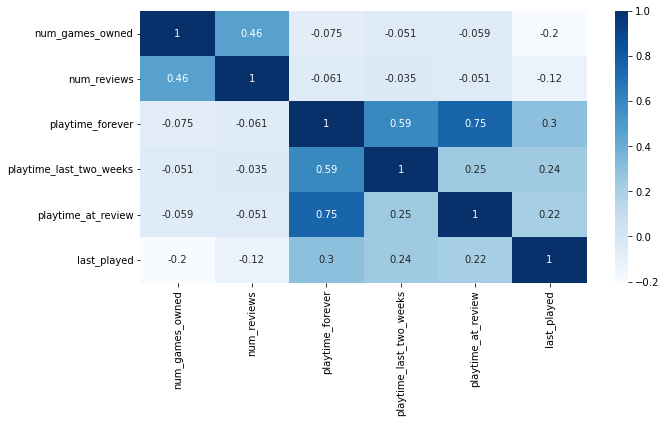

In [16]:
plt.figure(figsize=(10,5))
sns.heatmap(df_author.corr(),cbar=True,annot=True,cmap='Blues')

It can be seen that there is a strong correlation (defined as >0.7) of 0.8 between the reviewer's playtime at the time of review, and their total playtime for the game.

Plot a histogram showing what most of the reviewers playtimes at review are.

<AxesSubplot:xlabel='playtime_at_review', ylabel='Count'>

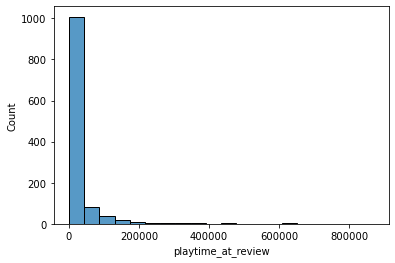

In [17]:
sns.histplot(df_author.playtime_at_review,bins=20)

Plot the relationship between playtime_at_review and playtime_forever

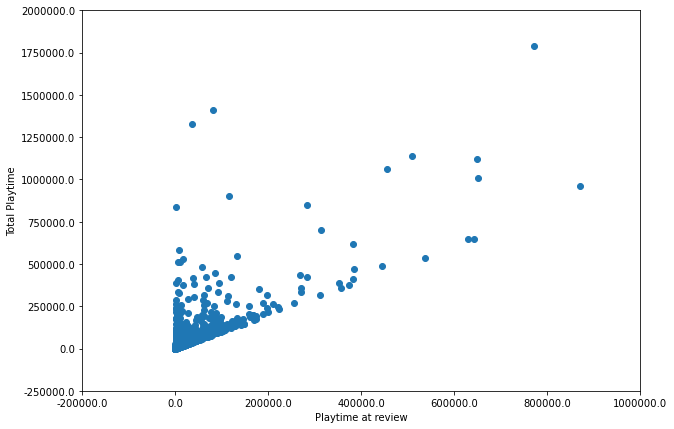

In [18]:
plt.figure(figsize=(10,7))
plt.scatter(x='playtime_at_review',y='playtime_forever',data=df_author)
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0])
plt.xticks(ticks=plt.xticks()[0], labels=plt.xticks()[0])
plt.xlabel('Playtime at review')
plt.ylabel('Total Playtime')

plt.show()

A lot of the playtime at review values fall under 200-300,000  and total playtime under 500,000. Resize the graph to reflect this.

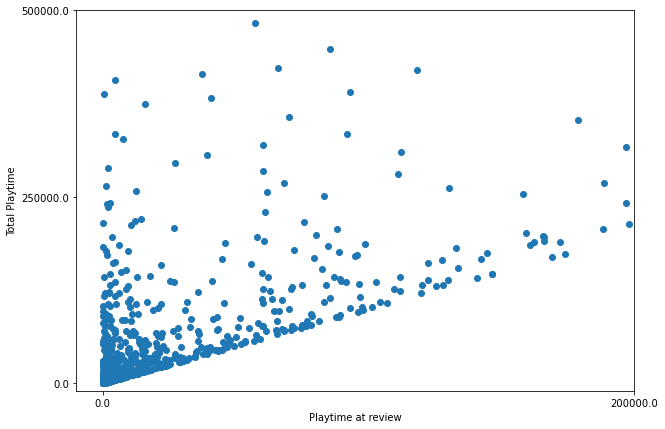

In [19]:
plt.figure(figsize=(10,7))
plt.scatter(x='playtime_at_review',y='playtime_forever',data=df_author)
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0])
plt.xticks(ticks=plt.xticks()[0], labels=plt.xticks()[0])
plt.xlabel('Playtime at review')
plt.ylabel('Total Playtime')

plt.xlim(left=-10000,right=200000)
plt.ylim(bottom=-10000,top=500000)

plt.show()

Add 'steamid' column from df_author back into dataframe containing reviews. 

This will be the foreign key for the df_author dataframe.

In [20]:
df['steamid'] = df_author['steamid']

Reorder the 'author_id' column to immediately after 'author', and drop the 'author' column

In [21]:
list(df.columns)

['recommendationid',
 'author',
 'language',
 'review',
 'timestamp_created',
 'timestamp_updated',
 'voted_up',
 'votes_up',
 'votes_funny',
 'weighted_vote_score',
 'comment_count',
 'steam_purchase',
 'received_for_free',
 'written_during_early_access',
 'steamid']

In [22]:
df = df[
    ['recommendationid',
     'steamid',
     'language',
     'review',
     'timestamp_created',
     'timestamp_updated',
     'voted_up',
     'votes_up',
     'votes_funny',
     'weighted_vote_score',
     'comment_count',
     'steam_purchase',
     'received_for_free',
     'written_during_early_access',
     ]
    ]

df.head()

,recommendationid,steamid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,118057004,76561197993103773,portuguese,ola que se passa com o jogo \ndiz erro de cone...,1656762394,1656762394,True,0,0,0,0,False,False,False
1,117936665,76561199352887065,english,Well designed and interesting. GL continually...,1656604756,1656604756,True,0,0,0,0,False,True,False
2,117802415,76561199278500439,english,I like the feature of chat as you are able to ...,1656433810,1656433810,True,0,0,0,0,False,True,False
3,117547089,76561199211042912,english,Great Game,1656116447,1656116447,True,0,0,0,0,False,False,False
4,117429346,76561199272140924,english,YES GOOD GAME,1655934675,1655934675,True,1,0,0.523809552192687988,0,False,True,False


Check to see if the dataframe datatypes are ideal.

In [23]:
df.dtypes

recommendationid               object
steamid                        object
language                       object
review                         object
timestamp_created               int64
timestamp_updated               int64
voted_up                         bool
votes_up                        int64
votes_funny                     int64
weighted_vote_score            object
comment_count                   int64
steam_purchase                   bool
received_for_free                bool
written_during_early_access      bool
dtype: object

The 'weighted_vote_score' should be changed to a float.

In [24]:
df['weighted_vote_score'] = df['weighted_vote_score'].astype('float64')
df.dtypes

recommendationid                object
steamid                         object
language                        object
review                          object
timestamp_created                int64
timestamp_updated                int64
voted_up                          bool
votes_up                         int64
votes_funny                      int64
weighted_vote_score            float64
comment_count                    int64
steam_purchase                    bool
received_for_free                 bool
written_during_early_access       bool
dtype: object

### Output to SQL

Output the tables to SQL for data storage.

A helper function to create a MySQL connection.

In [25]:
import pymysql
from sqlalchemy import create_engine

Create engine and connect to SQL

In [26]:
user='root'
password=getpass('Enter password: ')
host='localhost'
port='3306'

try:
    engine = create_engine(fr'mysql+pymysql://{user}:{password}@{host}:{port}', echo=False)
    print('SQL connection created.')
except Exception as e:
    print(f'Exception occured: {e}')

Enter password: ········
SQL connection created.


Set up the database for loading

In [27]:
engine.execute('DROP database IF EXISTS march_of_empires')
engine.execute('CREATE DATABASE march_of_empires')
engine.execute('USE march_of_empires')

df_author.to_sql(name='authors', con=engine, if_exists = 'replace', index=False)
df.to_sql(name='reviews', con=engine, if_exists = 'replace', index=False);

Double check in MySQL to see that the tables have sucessfully loaded.

*Authors table*
![Authors](img/sql1.png)

*Reviews table*
![Reviews](img/sql2.png)

### Modify the datatypes and keys of the database

Set up the primary/foreign keys and datatypes

In [28]:
# change data types for id columns to bigint
engine.execute('ALTER TABLE authors MODIFY COLUMN steamid bigint')
engine.execute('ALTER TABLE reviews MODIFY COLUMN steamid bigint')
engine.execute('ALTER TABLE reviews MODIFY COLUMN recommendationid bigint')

# set authors.steamid as authors PK
engine.execute('ALTER TABLE authors ADD PRIMARY KEY (steamid)')

# set reviews.recommendationid as reviews PK
engine.execute('ALTER TABLE reviews ADD PRIMARY KEY (recommendationid)')

# set reviews.steamid as reviews a FK
engine.execute('ALTER TABLE reviews ADD FOREIGN KEY (steamid) REFERENCES authors(steamid)')

## SQL Queries
For related SQL queries, see "march_of_empires.sql" in the file directory.

## Data Processing

We are interested in what the reviewers have to say about the game. So the column of most interest is 'review'

Reviews in languages besides English will require additional language translation. So we will limit the language to English for now.

Isolate the reviews column as a new Pandas Series.

In [29]:
df_english = df[df['language']=='english']

# interested in english reviews column
reviews_english = df_english['review']
reviews_english

1       Well designed and interesting.  GL continually...
2       I like the feature of chat as you are able to ...
3                                              Great Game
4                                           YES GOOD GAME
9       You have to stay active, to keep the gold comi...
                              ...                        
1171    Been playing for 4 months on mobile, game is c...
1173                               P2W. Dont even bother.
1174                                                  p2w
1178    SHITTY GAME JUST A STANDARD P2W game dont spen...
1179                          Gameloft = Phone port trash
Name: review, Length: 423, dtype: object

In [30]:
df_english

,recommendationid,steamid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
1,117936665,76561199352887065,english,Well designed and interesting. GL continually...,1656604756,1656604756,True,0,0,0.000000,0,False,True,False
2,117802415,76561199278500439,english,I like the feature of chat as you are able to ...,1656433810,1656433810,True,0,0,0.000000,0,False,True,False
3,117547089,76561199211042912,english,Great Game,1656116447,1656116447,True,0,0,0.000000,0,False,False,False
4,117429346,76561199272140924,english,YES GOOD GAME,1655934675,1655934675,True,1,0,0.523810,0,False,True,False
9,116605762,76561198042708364,english,"You have to stay active, to keep the gold comi...",1654555451,1654555451,False,0,0,0.000000,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,38237289,76561198016119609,english,"Been playing for 4 months on mobile, game is c...",1513006629,1513006629,True,8,0,0.349722,0,False,False,False
1173,38237193,76561198033517329,english,P2W. Dont even bother.,1513006367,1513006367,False,19,1,0.583463,0,False,False,False
1174,38236440,76561198113186156,english,p2w,1513004338,1513004338,False,9,1,0.569310,1,False,False,False
1178,38233104,76561198073326208,english,SHITTY GAME JUST A STANDARD P2W game dont spen...,1512992940,1512992940,False,48,2,0.684685,0,False,False,False


Clean the text for further analysis. Keep only basic punctuation (?,!.;:) and set all to lowercase for easier string matching. Refer to the transformed data as 'reviews_basic' 

In [31]:
#keep letters, numbers, basic punctuation, space
whitelist = set(string.digits+string.ascii_letters+r' .?!;'+'\'')  
reviews_basic = []

# clean the reviews
for review_raw in reviews_english:
    # remove line and tab breaks, make all lowercase
    temp = ''.join(filter(whitelist.__contains__, review_raw.replace('\n',' ').replace('\t',' '))).lower()
    reviews_basic.append(temp)

In [32]:
reviews_english=reviews_english.reset_index(drop=True)
reviews_english

0      Well designed and interesting.  GL continually...
1      I like the feature of chat as you are able to ...
2                                             Great Game
3                                          YES GOOD GAME
4      You have to stay active, to keep the gold comi...
                             ...                        
418    Been playing for 4 months on mobile, game is c...
419                               P2W. Dont even bother.
420                                                  p2w
421    SHITTY GAME JUST A STANDARD P2W game dont spen...
422                          Gameloft = Phone port trash
Name: review, Length: 423, dtype: object

In [33]:
# compare a random raw and cleaned
i = random.randint(0,len(reviews_english))
print(f'Raw:\n {reviews_english[i]}')
print(f'\nClean:\n {reviews_basic[i]}')

Raw:
 this game is best.

Clean:
 this game is best.


In addition, some acronyms such as "P2W" (pay to win) will be of interest. 

So it will be useful to convert all acronyms similar to this to a full phrase.

First, define a dictionary/phrase book of commonly used gaming terms.

Reference: https://ag.hyperxgaming.com/article/8983/gaming-acronyms-every-gamer-should-know

In [34]:
ACRONYMS_DICT = {
                'rpg': 'role playing game',
                'rts': 'real time strategy',
                'tbs': 'turn based strategy',
                'fps': 'frames per second',
                'tps': 'third person shooter',
                'br': 'battle royale',
                'moba': 'multiplayer online battle arena',
                'mmo': 'massively multiplayer online',
                'tcg' : 'trading card game',
                'ccg': 'collectible card game',
                'dlc' : 'downloadable content',
                'p2w' : 'pay to win',
                'p2p' : 'pay to play',
                'glhf': 'good luck, have fun',
                'gg' : 'good game',
                'ggwp': 'good game well played',
                'wp': 'well played',
                'afk': 'away from keyboard',
                #'pog': 'pog', # not acronym - shock/surprise
                #'pogchamp' : 'pogchamp', # not acronym - shock/surprise
                #'kappa' : 'kappa', # not acroynym - sarcasm/humor
                'fgc' : 'fighting game community',
                'op' : 'overpowered', # can also mean 'original poster' in a comment/forum thread
                'up' : 'underpowered',
                #'buff' : 'buff', # not acronym - strengthen
                #'nerf' : 'nerf', # not acronym - weaken
                'ui' : 'user interface',
                'hud' : 'heads up display', 
                'fov': 'field of view',
                'los': 'line of sight',
                'aoe': 'area of effect', 
                'dps': 'damage per second',
                'dot': 'damage over time',
                'aggro' : 'aggro', # not acronym - aggrevate/draw attention
                'cs' : 'creep score', # unique to mobas
                'pvp' : 'player vs player',
                'pve' : 'player vs environment',
                'npc' : 'non player character',
                'hp' : 'health', # or health points
                'mp' : 'mana', # or mana points
                'xp' : 'experience', # or experience points
                'mvp' : 'most valuable player'
                }

Helper functions to replace acronyms with words. 

In [35]:
def acronym_to_words(review,acronyms_dict):
    '''
    Convert any acronyms to words given a user review.
    Args: review --> str
    Returns: review_no_acronyms --> str
    '''
    review_word_lst = review.split()
    count = 0
    for word in review_word_lst:
        if word in acronyms_dict:
            # replace with word from acronyms dict
            review_word_lst[review_word_lst.index(word)] = acronyms_dict[word]
            count+=1
    return count,' '.join(review_word_lst)

def replace_acronyms(reviews_list,acronyms_dict):
    '''
    Replace all acronyms with words/phrases
    Args: reviews_list --> list, acronyms_dict --> dict
    Returns: reviews_list --> list
    '''
    total = 0
    reviews_list_no_acronyms = []
    for review in reviews_list:
        result = acronym_to_words(review,acronyms_dict)
        total += result[0]
        reviews_list_no_acronyms.append(result[1])
    print(f'Total of {total} acronyms changed.')
    return reviews_list_no_acronyms

Remove any relevant acronyms, and refer to the transformed data as 'reviews_no_acronyms'

In [36]:
reviews_no_acronyms = replace_acronyms(reviews_basic,ACRONYMS_DICT)
reviews_no_acronyms[:3]

Total of 70 acronyms changed.


['well designed and interesting. gl continually deploys new features to keep us engaged.',
 'i like the feature of chat as you are able to speak with players from around the globe and join in alliances to advance your champion',
 'great game']

Join the cleaned reviews back to the Dataframe. Keep the reviews in sentence list format seperate for now, but these can be  added back anytime.

In [37]:
cols = list(df_english.columns)
cols

['recommendationid',
 'steamid',
 'language',
 'review',
 'timestamp_created',
 'timestamp_updated',
 'voted_up',
 'votes_up',
 'votes_funny',
 'weighted_vote_score',
 'comment_count',
 'steam_purchase',
 'received_for_free',
 'written_during_early_access']

In [38]:
df_english.columns.get_loc('timestamp_created')

4

In [39]:
# insert to right after 'review'
df_english.insert(df_english.columns.get_loc('timestamp_created'), 'review_clean', reviews_no_acronyms)
df_english

,recommendationid,steamid,language,review,review_clean,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
1,117936665,76561199352887065,english,Well designed and interesting. GL continually...,well designed and interesting. gl continually ...,1656604756,1656604756,True,0,0,0.000000,0,False,True,False
2,117802415,76561199278500439,english,I like the feature of chat as you are able to ...,i like the feature of chat as you are able to ...,1656433810,1656433810,True,0,0,0.000000,0,False,True,False
3,117547089,76561199211042912,english,Great Game,great game,1656116447,1656116447,True,0,0,0.000000,0,False,False,False
4,117429346,76561199272140924,english,YES GOOD GAME,yes good game,1655934675,1655934675,True,1,0,0.523810,0,False,True,False
9,116605762,76561198042708364,english,"You have to stay active, to keep the gold comi...",you have to stay active to keep the gold comin...,1654555451,1654555451,False,0,0,0.000000,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,38237289,76561198016119609,english,"Been playing for 4 months on mobile, game is c...",been playing for 4 months on mobile game is cr...,1513006629,1513006629,True,8,0,0.349722,0,False,False,False
1173,38237193,76561198033517329,english,P2W. Dont even bother.,p2w. dont even bother.,1513006367,1513006367,False,19,1,0.583463,0,False,False,False
1174,38236440,76561198113186156,english,p2w,pay to win,1513004338,1513004338,False,9,1,0.569310,1,False,False,False
1178,38233104,76561198073326208,english,SHITTY GAME JUST A STANDARD P2W game dont spen...,shitty game just a standard pay to win game do...,1512992940,1512992940,False,48,2,0.684685,0,False,False,False
